In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [3]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super(LSTM, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1, 1, self.hidden_layer_size),
                            torch.zeros(1, 1, self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]


In [4]:
# Load and prepare data
data = pd.read_csv("D:/WEEK11 data/historical_data.csv", skiprows=2)
data.columns = ['Date', 'Close_BND', 'Close_SPY', 'Close_TSLA', 'High_BND', 'High_SPY', 'High_TSLA',
                'Low_BND', 'Low_SPY', 'Low_TSLA', 'Open_BND', 'Open_SPY', 'Open_TSLA',
                'Volume_BND', 'Volume_SPY', 'Volume_TSLA']
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
tsla_close = data['Close_TSLA']


In [5]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq, train_label))
    return inout_seq

train_data = torch.FloatTensor(tsla_close.values).view(-1)
train_window = 60
train_inout_seq = create_inout_sequences(train_data, train_window)


In [6]:
# Load the trained model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTM().to(device)
model.load_state_dict(torch.load('D:/KAIM/WEEK 11/KAIM WEEK11/notebooks/best_lstm_model.pth'))
model.eval()


LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

In [7]:
# Generate forecast for 6-12 months
test_inputs = train_data[-train_window:].tolist()
forecast_length = 252  # Number of days (approximately 12 months)
for i in range(forecast_length):
    seq = torch.FloatTensor(test_inputs[-train_window:]).to(device)
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size).to(device),
                        torch.zeros(1, 1, model.hidden_layer_size).to(device))
        test_inputs.append(model(seq).item())

# Get the forecasted values
future_predictions = test_inputs[train_window:]


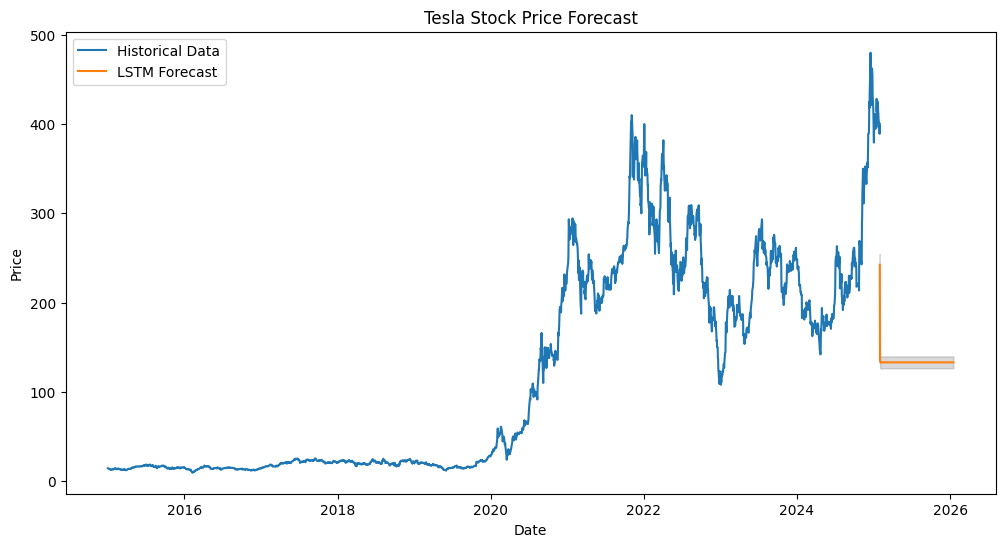

In [9]:
import numpy as np
# Plot the historical data and future predictions
plt.figure(figsize=(12, 6))
plt.plot(tsla_close.index, tsla_close.values, label='Historical Data')
plt.plot(pd.date_range(start=tsla_close.index[-1], periods=forecast_length, freq='B'), future_predictions, label='LSTM Forecast')
plt.fill_between(pd.date_range(start=tsla_close.index[-1], periods=forecast_length, freq='B'),
                 np.array(future_predictions) * 0.95, np.array(future_predictions) * 1.05, color='gray', alpha=0.3)
plt.title('Tesla Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [10]:
# Evaluation Metrics
test_data = torch.FloatTensor(tsla_close[-forecast_length:].values).view(-1)
mae_lstm = mean_absolute_error(test_data.cpu().numpy(), future_predictions)
rmse_lstm = np.sqrt(mean_squared_error(test_data.cpu().numpy(), future_predictions))
mape_lstm = np.mean(np.abs((test_data.cpu().numpy() - future_predictions) / test_data.cpu().numpy())) * 100

print(f"LSTM Model MAE: {mae_lstm}")
print(f"LSTM Model RMSE: {rmse_lstm}")
print(f"LSTM Model MAPE: {mape_lstm}%")

LSTM Model MAE: 111.44035339355469
LSTM Model RMSE: 139.6955115152237
LSTM Model MAPE: 40.19943371442447%
